# Librairies and functions

In [1]:
import numpy as np
import pandas as pd
import igraph as ig
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
import json, re, gc, requests, os
from tqdm import tqdm

In [2]:
plt.ion()
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
n = 2
plt.rc('axes', linewidth=n)
ticksSizeMajor = 10
ticksSizeMinor = 5
ticksWidth = n
ticksLabelSize = 20
axisLabelSize = 25
titleSize = 30
legendSize = 20

In [ ]:
path_input = r'/my/path/input'
path_output = r'/my/path/output'

# 1 - Open the main files

- `Papers_neuroscience_all.json` 
- `Papers_neuroscience_and_AI.json`
- `ExtraPapers_from_authors.csv`
- `citationNetwork.csv`
- `journals_MAG2WOS.csv`
- `AI_kw_classification.txt`
- `author2paper.csv`
- `authorId_name_affiliation.csv`

## 1.1 - Read the whole large database of neuroscience papers

In [5]:
with open(f'{path_input}Papers_neuroscience_all.json', 'r') as f:
    data = json.load(f)
data = pd.DataFrame.from_dict(data)

In [7]:
data.columns

Index(['id', ' publicationDate', ' issueIdentifier', ' created', ' publisher',
       ' volume', ' startingPage', ' endingPage', ' citationCount', ' doi',
       ' title', ' referenceCount', ' appearsInJournal', 'queryLevel',
       'authors', ' bookTitle', ' appearsInConferenceSeries',
       ' appearsInConferenceInstance'],
      dtype='object')

## 1.2 - Read the whole citation network containing no isolated nodes, ie. total degree $\neq$ 0
Here one citation link is directed such that 'citing' is 'source' and 'cited' is 'target'

In [ ]:
CN = ig.Graph.DataFrame(pd.read_csv(f'{path_input}citationNetwork.csv', sep=',', usecols=['citing', 'cited']), directed=True)
nodes = [CN.vs[i]['name'] for i in range(len(CN.vs))]

# 2 - Build a global egocentered dataset for citation network study
Build a subdataframe containing only papers containing at least one edge (coming inside or outside) in the whole citation network. We consider here only first 'in' and 'out' level of citation.

The index "queryLevel" index indicates here the presence of a given article inside the originally extracted neuroscience dataset (value 0, egocentered) or not (value 1, those added for the citation network).

In [10]:
subdata = data[['id', 'queryLevel', ' title',' publicationDate', ' appearsInJournal', 'authors']].reset_index(drop=True)
subdata.rename(columns = {' publicationDate': 'publicationYear', ' appearsInJournal': 'idJournal', ' title':'title'}, inplace=True)
#subdata['title'] = subdata['title'].apply(lambda x: eval(x))
subdata['publicationYear'].fillna('-1', inplace=True)
subdata['publicationYear'] = [int(re.findall(r'\d+', i)[0]) if i != '-1' else -1 for i in subdata['publicationYear']]
subdata['idJournal'].fillna(-1, inplace=True)
subdata['idJournal'] = [int(i) if i != -1 else -1 for i in subdata['idJournal']]
subdata

,id,queryLevel,title,publicationYear,idJournal,authors
0,2038431747,0,"""Topology learning solved by extended objects...",1994,207023548,"[2163422316, 2419355596, 2289589767]"
1,1010827267,0,"""Multipotent Stem Cells In Murine Sclera""",2011,76304953,"[2482935619, 2618323644, 2661080946, 266108094..."
2,2411724805,0,"""Comparative study on results of prefrontal l...",1953,124451323,"[2987759242, 2631162769, 2651065461]"
3,2004877318,0,"""Ventral frontal deficits in psychopathy: Neu...",1995,165368631,"[2572627602, 2278535667, 2800225512]"
4,2025848838,0,"""Iowa gambling task in Parkinson&#039",2011,35508115,"[237217217, 2129310074, 2647734675]"
...,...,...,...,...,...,...
14028712,2080374763,1,"""The spectral sensitivity of light-adapted ca...",1954,2090548,[2684787159]
14028713,2147483632,1,"""The 5-hydroxytryptamine (serotonin) receptor...",2013,136368880,"[2145232497, 2336850026, 2671773241, 144628305..."
14028714,2181038068,1,"""Giving machines humanlike eyes""",2015,66124381,"[2974799061, 2723812261, 2617766515]"
14028715,2147483638,1,"""Effect of three anaesthetic techniques on is...",2004,33418846,"[2308317210, 2070658732, 2496673173, 2930434804]"


## 2.1 - Add journals' name and associated discipline from WoS classification

In [2]:
def wos_split_strings(list_str):
    l = []
    for i in list_str:
        l += re.split(' \| ', i) # change separators if needed
    return l

In [12]:
# read the WoS disciplinary classification and add it to the journals database
JournalsDisciplines = pd.read_csv(f'{path_input}journals_MAG2WOS.csv', sep=';')
JournalsDisciplines.rename(columns={'MAG_journal_Id': 'idJournal'}, inplace=True)
JournalsDisciplines = JournalsDisciplines.groupby('idJournal').agg(lambda x: x.tolist()).reset_index()
JournalsDisciplines['Web of Science Categories'] = [wos_split_strings(i) for i in JournalsDisciplines['Web of Science Categories']]
JournalsDisciplines

,idJournal,Journal title,Web of Science Categories
0,61661,[JOURNAL OF PROSTHODONTICS-IMPLANT ESTHETIC AN...,"[Dentistry, Oral Surgery & Medicine]"
1,81127,[EUROPEAN HEART JOURNAL SUPPLEMENTS],[Cardiac & Cardiovascular System]
2,146344,[JOURNAL OF MARRIAGE AND FAMILY],"[Sociology, Family Studies]"
3,161885,[CHINESE STUDIES IN HISTORY],"[History, Asian Studies]"
4,182001,[GIFTED CHILD QUARTERLY],"[Psychology, Educational, Education, Special]"
...,...,...,...
17605,3035668652,[EUROPEAN RADIOLOGY EXPERIMENTAL],"[Radiology, Nuclear Medicine & Medical Imaging]"
17606,3035671286,[SATELLITE NAVIGATION],"[Engineering, Aerospace, Telecommunications, R..."
17607,3035730399,[JOURNAL OF THE EGYPTIAN PUBLIC HEALTH ASSOCIA...,"[Public, Environmental & Occupational Health]"
17608,3035751226,[JOURNAL OF PATIENT-REPORTED OUTCOMES],"[Health Care Sciences & Services, Health Polic..."


In [13]:
subdata = pd.merge(subdata, JournalsDisciplines, on='idJournal', how='left')
subdata.rename(columns={'Journal title': 'journal_title', 'Web of Science Categories': 'wos_domains'}, inplace=True)

## 2.2 - Add AI keywords and main classes if `isIA=1`

In [15]:
# read intersection dataset neuro and IA
with open(f'{path_input}Papers_neuroscience_and_AI.json', 'r') as f:
    dataIA = json.load(f)
dataIA = pd.DataFrame.from_dict(dataIA)

In [56]:
dataIA

,id,publicationDate,issueIdentifier,created,publisher,volume,startingPage,endingPage,citationCount,doi,title,referenceCount,appearsInJournal,queryLevel,authors,bookTitle,appearsInConferenceSeries,appearsInConferenceInstance,abstract,keywordsIA
0,2982150161,"""2020-03-07""",NaN,"""2019-11-01""","""Elsevier""","""380""","""11""","""19""","""1""",10.1016/J.NEUCOM.2019.10.001,"""Delay tolerant containment control for secon...","""32""",45693802,0,"[2698853177, 2894619631, 2090493536, 2980724061]",NaN,NaN,NaN,"Abstract In this paper, a delay tolerant cont...","[convex hull, multi-agent system]"
1,2017460423,"""2004-12-01""","""4""","""2016-06-24""","""Lippincott Williams and Wilkins""","""14""","""187""","""189""","""0""",10.1097/00041444-200412000-00003,"""Evaluation of genetic substructure in the Ir...","""0""",41645954,0,"[2494464687, 2120665394, 2091809267, 2614997734]",NaN,NaN,NaN,: The presence of genetic substructure has th...,[markov chain monte carlo]
2,2592080110,"""2017-03-03""",NaN,"""2017-03-16""","""Dove Press""","""9""","""39""","""57""","""36""",10.2147/NSS.S103467,"""New developments in the management of narcol...","""0""",2739268901,0,"[2162133358, 2136137024]",NaN,NaN,NaN,": Narcolepsy is a life-long, underrecognized ...",[mycin]
3,2613051638,"""2017-07-01""",NaN,"""2017-05-19""","""Elsevier""","""158""","""7""","""13""","""0""",10.1016/J.PBB.2017.05.004,"""Posterior hypothalamus glutamate infusion de...","""51""",59685179,0,"[2049946654, 2108670995, 2944770929, 2667938519]",NaN,NaN,NaN,Abstract Objectives Seizures are epileptic ma...,[lenet]
4,2617245985,"""2017-11-29""",NaN,"""2017-06-05""","""Elsevier""","""266""","""325""","""335""","""15""",10.1016/J.NEUCOM.2017.05.042,"""Deep learning algorithms for discriminant au...","""36""",45693802,0,"[3024761849, 2619442247]",NaN,NaN,NaN,"In this paper, a new family of Autoencoders (...","[autoencoder, dimensionality reduction]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614353,1979711143,"""1998-07-24""","""3""","""2016-06-24""","""ACM""","""37""","""209""","""217""","""937""",10.1145/279943.279985,"""Large margin classification using the percep...","""21""",NaN,1,"[2985572601, 2626311920]","""COLT""",1177622950,2786194060,We introduce and analyze a new algorithm for ...,[classifier]
614354,2147483361,"""2011-04-01""","""4""","""2016-06-24""","""IEEE""","""33""","""754""","""766""","""137""",10.1109/TPAMI.2010.133,"""Harvesting Image Databases from the Web""","""26""",199944782,1,"[2985357453, 1966707555, 2469405535]",NaN,NaN,NaN,The objective of this work is to automaticall...,"[training data, classifier]"
614355,2919235374,"""2019-05-01""",NaN,"""2019-03-11""","""Academic Press""","""61""","""42""","""49""","""2""",10.1016/J.JVCIR.2019.03.004,"""Application of artificial intelligence algor...","""24""",105424869,1,"[2919870832, 2919889170]",NaN,NaN,NaN,Abstract As the main media of human communica...,"[artificial intelligence, combinatorial optimi..."
614356,2046820148,"""2014-03-20""","""3""","""2016-06-24""","""Public Library of Science""","""9""",NaN,NaN,"""52""",10.1371/JOURNAL.PONE.0091969,"""Visceral adiposity index (VAI) is predictive...","""41""",202381698,1,"[45745419, 1900658159, 3005837255, 2080409075,...",NaN,NaN,NaN,Aims Although there is still no clear definit...,[cluster analysis]


In [67]:
# read the classification of AI keywords
classification = pd.read_csv(f'{path_input}AI_kw_classification.txt', sep=';', names=['keywords', 'class'])
classification['keywords'] = [i.strip() for i in classification['keywords']]
classification

,keywords,class
0,evolutionary algorithm,optimization
1,simulated annealing,optimization
2,hierarchical clustering,cluster analysis
3,principal component analysis,cluster analysis
4,unsupervised learning,machine learning
...,...,...
527,multi swarm optimization,optimization
528,fast and frugal trees,AI general
529,chess playing computer,robotics
530,bias variance tradeoff,optimization


In [17]:
dataIA['classIA'] = (dataIA['keywordsIA'].apply(
    lambda x: list(set([classification[classification['keywords']==k]['class'].values[0] for k in x if len(classification[classification['keywords']==k]['class'].values) != 0]))))

In [17]:
subdata['isIA'] = np.where(subdata['id'].isin(dataIA['id']), 1, 0)
subdata = pd.merge(subdata, dataIA[['id', 'keywordsIA', 'classIA']], on='id', how='left').fillna(-1)
subdata

,id,queryLevel,title,publicationYear,idJournal,authors,isIA
0,2038431747,0,"""Topology learning solved by extended objects...",1994,207023548,"[2163422316, 2419355596, 2289589767]",0
1,1010827267,0,"""Multipotent Stem Cells In Murine Sclera""",2011,76304953,"[2482935619, 2618323644, 2661080946, 266108094...",0
2,2411724805,0,"""Comparative study on results of prefrontal l...",1953,124451323,"[2987759242, 2631162769, 2651065461]",0
3,2004877318,0,"""Ventral frontal deficits in psychopathy: Neu...",1995,165368631,"[2572627602, 2278535667, 2800225512]",0
4,2025848838,0,"""Iowa gambling task in Parkinson&#039",2011,35508115,"[237217217, 2129310074, 2647734675]",0
...,...,...,...,...,...,...,...
14028712,2080374763,1,"""The spectral sensitivity of light-adapted ca...",1954,2090548,[2684787159],0
14028713,2147483632,1,"""The 5-hydroxytryptamine (serotonin) receptor...",2013,136368880,"[2145232497, 2336850026, 2671773241, 144628305...",0
14028714,2181038068,1,"""Giving machines humanlike eyes""",2015,66124381,"[2974799061, 2723812261, 2617766515]",0
14028715,2147483638,1,"""Effect of three anaesthetic techniques on is...",2004,33418846,"[2308317210, 2070658732, 2496673173, 2930434804]",0


In [334]:
del dataIA

## 2.3 - Save the final subdataframe

In [39]:
subdata.to_csv(f"{path_output}citationNetwork_nodes.csv", sep=';', index=False)
# del subdata

# 3 - Build filtered egocentered datasets for $\mathcal{P}\cap AI$ and $\mathcal{P}\cap \overline{AI}$
It includes papers with main attributes:
- `queryLevel=0`
- published after 1970
- cited at least 10 times, ie. $k_{in}\geqslant10$
- citing at least 10 other references, ie. $k_{out}\geqslant10$

## 3.1 - $\mathcal{P}\cap \overline{AI}$

Here `isIA=0`

In [12]:
data.fillna(-1, inplace=True)
data[' referenceCount'] = data[' referenceCount'].apply(lambda x: int(eval(x)) if x!=-1 else -1)
data[' citationCount'] = data[' citationCount'].apply(lambda x: int(eval(x)) if x!=-1 else -1)

In [42]:
# get only the ids of the papers that counts at least 10 reference and citation
ids_nbRefSup10nbImpSup10 = data[(data[' referenceCount'] >= 10)
                                & (data[' citationCount'] >= 10)]['id']

In [43]:
subdata_subset = subdata[(subdata['queryLevel']==0) 
                    & (subdata['isIA']==0) 
                    & (subdata['publicationYear']>=1970) # & (subdata['publicationYear']<2020) 
                    & (subdata['id'].isin(ids_nbRefSup10nbImpSup10))]

In [44]:
len(subdata_subset) # here 829317

829317

In [53]:
subdata_subset.to_csv(f"{path_output}papersNeuro_minRef10_minImp10_from1970.csv", sep=';', index=False)

In [8]:
# force to free memory
del data, CN, nodes
gc.collect()

0

## 3.2 - $\mathcal{P}\cap AI$

Here `isIA=1`

In [13]:
ids_nbRefSup10nbImpSup10 = data[(data[' referenceCount'] >= 10)
                                & (data[' citationCount'] >= 10)]['id']

In [25]:
subdata_subset = subdata[(subdata['queryLevel']==0) 
                    & (subdata['isIA']==1) 
                    & (subdata['publicationYear']>=1970) # & (subdata['publicationYear']<2020) 
                    & (subdata['id'].isin(ids_nbRefSup10nbImpSup10))]

In [50]:
len(subdata_subset) # here 26374

26374

In [54]:
subdata_subset.to_csv(f"{path_output}papersNeuroAI_minRef10_minImp10_from1970.csv", sep=';', index=False)

## 3.3 - Compare the structure of the original citation network with the one produced by the filtered datasets

In [4]:
links = pd.read_csv(f'{path_input}citationNetwork.csv', sep=',', usecols=['citing', 'cited'])
nodes = pd.read_csv(f'{path_output}citationNetwork_nodes.csv', sep=';')
nodes_AI = nodes[(nodes['queryLevel']==0)&(nodes['isIA']==1)]

In [9]:
nodes_filtered_AI = pd.read_csv(f'{path_output}papersNeuroAI_minRef10_minImp10_from1970.csv', sep=';')
nodes_filtered_nonAI =  pd.read_csv(f'{path_output}papersNeuro_minRef10_minImp10_from1970.csv', sep=';')
nodes_filtered = pd.concat([nodes_filtered_AI,nodes_filtered_nonAI])

In [8]:
CN_tot = nx.from_pandas_edgelist(links, source='citing', target='cited', edge_attr=None, create_using=nx.DiGraph, edge_key=None)
degree_freq = nx.degree_histogram(CN_tot)

In [17]:
'''
with open(f'{path_input}citation_net_degreeHisto.txt', 'w') as f:
    for d in degree_freq:
        f.write(str(d)+'\n')
with open(f'{path_input}citation_net_degreeHisto.txt', 'r') as f:
    degree_freq = [int(g[:-1]) for g in f.readlines()]
'''

In [10]:
links_filtered = links[(links['cited'].isin(nodes_filtered['id']))
                       |(links['citing'].isin(nodes_filtered['id']))]

In [11]:
CN_filtered = nx.from_pandas_edgelist(links_filtered, source='citing', target='cited', edge_attr=None, create_using=nx.DiGraph, edge_key=None)
degree_freq_filtered = nx.degree_histogram(CN_filtered)

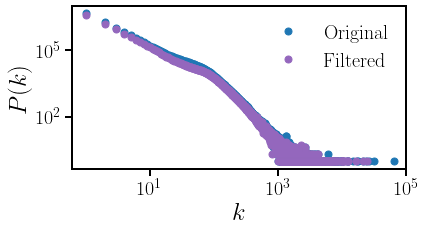

In [45]:
cmap = plt.cm.tab20.colors
ig = plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.plot(range(len(degree_freq)), degree_freq, marker='o',
        linewidth=0, color=cmap[0], markersize=7, label=r'Original', alpha=1)
ax.plot(range(len(degree_freq_filtered)), degree_freq_filtered, marker='o',
        linewidth=0, color=cmap[8], markersize=7, label=r'Filtered', alpha=1)
ax.set_xlabel(r'$k$', fontsize=axisLabelSize)
ax.set_xscale('log')
ax.set_ylabel(r'$P(k)$', fontsize=axisLabelSize)
ax.set_yscale('log')
ax.set_ylim(0.4,1e7)
ax.set_xlim(0.6,1e5)
#ax.set_xticks([10**i for i in range(6)], [10**i for i in range(6)])
ax.tick_params(which='major', labelsize=ticksLabelSize, length=7, width=ticksWidth)
ax.tick_params(which='minor', length=4, width=ticksWidth)
ax.legend(loc='upper right', ncol=1, fontsize=legendSize, frameon=False)
plt.savefig(f'{path_output}degree_distribs_OriginalDataset_vs_FilteredDataset.pdf', format='pdf', bbox_inches='tight')

# 4 - Build an egocentered collaboration network based on all publications (not only in neurosciences) of the authors
- Build a dataset of authors authors of the papers included in the set of neuroscience papers $\mathcal{P}$ (query level 0), based on all their publications, included those that are not in $\mathcal{P}$ (query level 2, extracted as well).
- Build a collaboration network centered on these authors.

## 4.1 - Build the author database
Since many files are used for the process, we recall here the basic steps for building such a database:
1) Get the authors from the neuroscience egocentered database (QL0), called `all_papers_QL0` in the following

2) Get their informations (name and affilitations) from a file imported under the variable `allAuthors_Ql0Ql1`

3) In order to compute their AI score overall their publications, add to the database QL0 the paper published by these authors but not inside QL0, saved in the file loaded under the variable `allpapers_Ql2` in the following. Then compute the AI score.

### 4.1.1 - Step 1

In [4]:
# only papers in qeryLevel=0, published since 1970 and that have at least 10 references and 10 impacts
papersAI = pd.read_csv(f"{path_output}papersNeuroAI_minRef10_minImp10_from1970.csv", sep=';')
papersNonAI = pd.read_csv(f"{path_output}papersNeuro_minRef10_minImp10_from1970.csv", sep=';')

In [25]:
allpapers_QL0 = pd.concat([papersAI,papersNonAI]).reset_index(drop=True)
allpapers_QL0['authors'] = [list(set(eval(i))) if i!='-1' else -1 for i in allpapers_QL0['authors']] # to avoid the double apparitions
allpapers_QL0['journal_title'] = [list(set(eval(i))) if i!='-1' else -1 for i in allpapers_QL0['journal_title']] # idem
allpapers_QL0['wos_domains'] = [list(set(eval(i))) if i!='-1' else -1 for i in allpapers_QL0['wos_domains']] # idem
allpapers_QL0['wos_domains_agg'] = allpapers_QL0['wos_domains'].apply(lambda x: list(set([i.split(', ')[0] for i in x])) if x!=-1 else -1)
allpapers_QL0['keywordsIA'] = [list(set(eval(i))) if i!=-1 else -1 for i in allpapers_QL0['keywordsIA']] # idem
allpapers_QL0['classIA'] = [list(set(eval(i))) if i!=-1 else -1 for i in allpapers_QL0['classIA']] # idem

In [9]:
# expand the big dataframe with respect to the authors
allpapers_QL0_expanded = allpapers_QL0.explode('authors').reset_index(drop=True)
allpapers_QL0_expanded

,id,queryLevel,publicationYear,idJournal,authors,journal_title,wos_domains,isIA,keywordsIA,classIA,wos_domains_agg
0,2617245985,0,2017,45693802,3024761849,[NEUROCOMPUTING],"[Computer Science, Artificial Intelligence]",1,"[autoencoder, dimensionality reduction]","[deep learning, cluster analysis]",[Computer Science]
1,2617245985,0,2017,45693802,2619442247,[NEUROCOMPUTING],"[Computer Science, Artificial Intelligence]",1,"[autoencoder, dimensionality reduction]","[deep learning, cluster analysis]",[Computer Science]
2,2021655074,0,2006,140962798,2145260682,[NEURAL PROCESSING LETTERS],"[Computer Science, Artificial Intelligence]",1,"[backpropagation, perceptrons]",[neural networks],[Computer Science]
3,2021655074,0,2006,140962798,2835622326,[NEURAL PROCESSING LETTERS],"[Computer Science, Artificial Intelligence]",1,"[backpropagation, perceptrons]",[neural networks],[Computer Science]
4,1790968754,0,2015,207023548,2995834608,[NEURAL COMPUTATION],"[Neurosciences, Computer Science, Artificial I...",1,[principal component analysis],[cluster analysis],"[Neurosciences, Computer Science]"
...,...,...,...,...,...,...,...,...,...,...,...
4026968,2046820344,0,2012,116196263,2579365867,[CORTEX],"[Behavioral Sciences, Neurosciences, Psycholog...",0,-1,-1,"[Psychology, Behavioral Sciences, Neurosciences]"
4026969,2046820344,0,2012,116196263,2016899951,[CORTEX],"[Behavioral Sciences, Neurosciences, Psycholog...",0,-1,-1,"[Psychology, Behavioral Sciences, Neurosciences]"
4026970,2046820344,0,2012,116196263,157945237,[CORTEX],"[Behavioral Sciences, Neurosciences, Psycholog...",0,-1,-1,"[Psychology, Behavioral Sciences, Neurosciences]"
4026971,2046820344,0,2012,116196263,2496737467,[CORTEX],"[Behavioral Sciences, Neurosciences, Psycholog...",0,-1,-1,"[Psychology, Behavioral Sciences, Neurosciences]"


### 4.1.2 - Step 2

In [13]:
# read the whole authors' dataframe including the authors of our publications (QL0)
# as well as those in references and impact (QL1)
allAuthors_Ql0Ql1 = pd.read_csv(f'{path_input}authorId_name_affiliation.csv', sep=',')
allAuthors_Ql0Ql1

,authorId,name,affiliation,queryLevel
0,1990375167,A.A.A.A Kusumawardhani,NONE,1
1,2663910298,A.A.A.A Nasser,NONE,1
2,2814684889,A A A Aarts,99464096,1
3,3020917786,A.A.A. Ahmed,NONE,1
4,2594650676,A. A. A. Aioub,7597260,1
...,...,...,...,...
15325785,2257106621,李哲雨,NONE,1
15325786,2516757462,李桂楨,NONE,1
15325787,2663157117,李永麟,NONE,1
15325788,2668056676,李相哲,NONE,1


In [14]:
# filter the big file for all authors in QL0 (data for neuroscience)
authorsInPapers = allAuthors_Ql0Ql1[allAuthors_Ql0Ql1['authorId'].isin(set(allpapers_QL0_expanded['authors'])-{-1})]
authorsInPapers

,authorId,name,affiliation,queryLevel
41,1550607070,A. A. A. M. Danen-van Oorschot,121797337,0
44,2505675405,A. A. A. Manik J. Djelantik,193662353,0
53,2806045187,A.A.A. Pradhan,5023651,0
72,2974182613,A. A. Aarnisalo,NONE,0
134,2991992674,A A Abdel-Latif,25041050,0
...,...,...,...,...
15262197,2263707641,Е. Viteva,NONE,0
15262570,3022633000,Е Е Garanina,21203515,0
15265271,2688406403,Мikhail Pashenkov,NONE,0
15269510,2495571327,І. L. Popovych,149851306,0


### 4.1.3 - Step 3

In [13]:
# open the link file of all authors with all their associated papers (QL0+QL2)
# drop duplicates: only unique link author-paper
allAuthors_Ql0_papers = pd.read_csv(f'{path_input}author2paper.csv', sep=',')
allAuthors_Ql0_papers.drop_duplicates(inplace=True)
#allAuthors_Ql0_papers = allAuthors_Ql0_papers.groupby('authorId').aggregate(list)
allAuthors_Ql0_papers

,authorId,paperId
0,2951562659,285
1,2535012878,348
2,2482451074,348
3,2060325654,527
4,2746639708,662
...,...,...
53855474,2785152602,3035763607
53855475,2852722787,3035763695
53855476,2650729909,3035763695
53855477,2159918643,3035763702


In [15]:
# add the total number of publications of the authors above
authorsInPapers = authorsInPapers.merge(pd.DataFrame.from_records(list(Counter(allAuthors_Ql0_papers['authorId']).items()), columns=['authorId', 'nb_publi_all']),
                                   on='authorId',
                                   how='outer').fillna(0)
authorsInPapers

,authorId,name,affiliation,queryLevel,nb_publi_all
0,1550607070,A. A. A. M. Danen-van Oorschot,121797337,0,6
1,2505675405,A. A. A. Manik J. Djelantik,193662353,0,11
2,2806045187,A.A.A. Pradhan,5023651,0,1
3,2974182613,A. A. Aarnisalo,NONE,0,2
4,2991992674,A A Abdel-Latif,25041050,0,8
...,...,...,...,...,...
1290136,2263707641,Е. Viteva,NONE,0,1
1290137,3022633000,Е Е Garanina,21203515,0,1
1290138,2688406403,Мikhail Pashenkov,NONE,0,1
1290139,2495571327,І. L. Popovych,149851306,0,1


In [6]:
# open the main file of publication containing all additionnal publication of the authors
allpapers_QL2 = pd.read_csv(f'{path_input}ExtraPapers_from_authors.csv', sep=';').fillna(-1)
allpapers_QL2['wos_domains'] = [list(set(eval(i))) if i!=-1 else -1 for i in allpapers_QL2['wos_domains']]
allpapers_QL2['wos_domains_agg'] = allpapers_QL2['wos_domains'].apply(lambda x: list(set([i.split(', ')[0] for i in x])) if x!=-1 else -1)
allpapers_QL2['journal_title'] =  allpapers_QL2['journal_title'].apply(lambda x: list(set(eval(x)))[0] if x!=-1 else -1)
allpapers_QL2['keywordsIA'] = [list(set(eval(i))) if i!=-1 else -1 for i in allpapers_QL2['keywordsIA']]
allpapers_QL2['classIA'] = [list(set(eval(i))) if i!=-1 else -1 for i in allpapers_QL2['classIA']]
allpapers_QL2['queryLevel'] = 2
allpapers_QL2

,id,publicationYear,title,idJournal,queryLevel,journal_title,wos_domains,isIA,keywordsIA,classIA,wos_domains_agg
0,1984623903,1981,"""F&#x00FC;nf neue Arten der Gattung Halacarus ...",4078192,2,ZOOLOGICA SCRIPTA,"[Zoology, Evolutionary Biology]",0,-1,-1,"[Zoology, Evolutionary Biology]"
1,1984624469,2014,"""Ultracompact three-dimensional tubular conduc...",143846845,2,NANO LETTERS,"[Physics, Condensed Matter, Nanoscience & Nano...",0,-1,-1,"[Materials Science, Physics, Chemistry, Nanosc..."
2,1984630132,2000,"""Enhanced dechlorination of Aroclor 1242 in an...",52566953,2,WATER RESEARCH,"[Environmental Sciences, Engineering, Environm...",0,-1,-1,"[Engineering, Environmental Sciences, Water Re..."
3,1984632460,1996,"""NEST PREDATION AND AVIAN LIFE-HISTORY EVOLUTI...",122176235,2,AMERICAN NATURALIST,"[Evolutionary Biology, Ecology]",0,-1,-1,"[Evolutionary Biology, Ecology]"
4,1984633284,2017,"""On the Matter of Suffering: Derek Parfit and ...",56047584,2,CRIMINAL LAW AND PHILOSOPHY,[Law],0,-1,-1,[Law]
...,...,...,...,...,...,...,...,...,...,...,...
24330847,2523645934,2013,"""Reproductive outcomes after bariatric surgery""",-1,2,-1,-1,0,-1,-1,-1
24330848,2523663736,2014,"""Nano-engineered PLLA based biomaterial drives...",68700368,2,JOURNAL OF TISSUE ENGINEERING AND REGENERATIVE...,"[Cell & Tissue Engineering, Cell Biology, Biot...",0,-1,-1,"[Engineering, Cell & Tissue Engineering, Biote..."
24330849,2523695446,2016,"""Executive functioning in autism spectrum diso...",-1,2,-1,-1,0,-1,-1,-1
24330850,2523696321,2006,"""Surr&#x00E9;nalectorme unilat&#x00E9;rale et ...",198822128,2,-1,-1,0,-1,-1,-1


In [22]:
# add the indicator 'isIA' from the QL2 dataset
allAuthors_Ql0_papers.rename(columns={'paperId':'id'}, inplace=True)
allAuthors_Ql0_papers = pd.merge(allAuthors_Ql0_papers, allpapers_QL2[['id','isIA']], on='id', how='left')

# add the indicator 'isIA' from the QL0 dataset by concatenation
allAuthors_Ql0_papers = pd.concat([allAuthors_Ql0_papers, 
                                   allpapers_QL0_expanded[['authors','id','isIA']].rename(columns={'authors':'authorId'})])
allAuthors_Ql0_papers          

,authorId,id,isIA
0,2951562659,285,0.0
1,2535012878,348,0.0
2,2482451074,348,0.0
3,2060325654,527,0.0
4,2746639708,662,0.0
...,...,...,...
4026968,2579365867,2046820344,0.0
4026969,2016899951,2046820344,0.0
4026970,157945237,2046820344,0.0
4026971,2496737467,2046820344,0.0


Compute the total AI score of the authors, based on the publications that are including abstracts. Be careful to skip `NaN` values due to double publications occurring in the cell above.

In [41]:
total_AIscore = allAuthors_Ql0_papers[['authorId','isIA']].groupby('authorId').aggregate(np.nanmean).reset_index(level=0)
total_AIscore.rename(columns={'isIA':'AIscore_all'}, inplace=True)
total_AIscore

,authorId,AIscore_all
0,-1,0.166667
1,18161,0.026316
2,20361,0.000000
3,39506,0.000000
4,57623,0.000000
...,...,...
1290137,3035759232,0.024390
1290138,3035760453,0.000000
1290139,3035760604,0.000000
1290140,3035761758,0.000000


In [45]:
# add the total AI score of the authors above
authorsInPapers = authorsInPapers.merge(total_AIscore,
                                   on='authorId',
                                   how='inner')
authorsInPapers

,authorId,name,affiliation,queryLevel,nb_publi_all,AIscore_all
0,1550607070,A. A. A. M. Danen-van Oorschot,121797337,0,6,0.0
1,2505675405,A. A. A. Manik J. Djelantik,193662353,0,11,0.0
2,2806045187,A.A.A. Pradhan,5023651,0,1,0.0
3,2974182613,A. A. Aarnisalo,NONE,0,2,0.0
4,2991992674,A A Abdel-Latif,25041050,0,8,0.0
...,...,...,...,...,...,...
1290136,2263707641,Е. Viteva,NONE,0,1,0.0
1290137,3022633000,Е Е Garanina,21203515,0,1,0.0
1290138,2688406403,Мikhail Pashenkov,NONE,0,1,0.0
1290139,2495571327,І. L. Popovych,149851306,0,1,0.0


### 4.1.4 - Save file

In [46]:
authorsInPapers.to_csv(f'{path_output}collabNet_nodes.csv', sep=';', index=False)
# save another file for Gephi
authorsInPapers.rename(columns={'authorId':'id','name':'label'}).to_csv(f'{path_output}/collabNet_nodes_gephi.csv', sep=';', index=False)

## 4.2 - Enrich the previous dataset with additional temporal and disciplinairy trajectories of the authors

In [4]:
authorsInPapers = pd.read_csv(f'{path_output}collabNet_nodes.csv', sep=';')

In [15]:
#  Concatenate the big files of papers
papers_years = pd.concat([allpapers_QL0[['id','queryLevel','publicationYear','idJournal','wos_domains_agg']],
                          allpapers_QL2[['id','queryLevel','publicationYear','idJournal','wos_domains_agg']]]).rename(columns={'id':'paperId'})

In [16]:
del allpapers_QL0, allpapers_QL2
gc.collect()

487

In [ ]:
allAuthors_Ql0_papers.rename(columns={'id':'paperId'},inplace=True)
allAuthors_Ql0_papers = allAuthors_Ql0_papers[allAuthors_Ql0_papers['id'].isin(papers_years['paperId'])]

In [21]:
authors_years_wos = pd.merge(allAuthors_Ql0_papers, papers_years, on='paperId', how='left')[['authorId','publicationYear','wos_domains_agg']]
authors_years_wos.fillna(-1, inplace=True)
#authors_years_wos['publicationYear'] = authors_years_wos['publicationYear'].astype(int)
authors_years_wos

,authorId,publicationYear,wos_domains_agg
0,2951562659,2012,"[Physics, Astronomy & Astrophysics]"
1,2535012878,2004,-1
2,2482451074,2004,-1
3,2060325654,2000,-1
4,2746639708,2001,-1
...,...,...,...
51963399,2768276645,2020,[Gastroenterology & Hepatology]
51963400,2328000574,2020,[Gastroenterology & Hepatology]
51963401,2653064050,2020,"[Medicine, Oncology]"
51963402,2831405835,2020,"[Engineering, Materials Science]"


In [30]:
authors_years_wos = authors_years_wos[authors_years_wos['publicationYear']<2020]
authors_years_wos = authors_years_wos.groupby(['authorId','publicationYear']).agg(list).reset_index()

In [32]:
authors_careers = authors_years_wos.drop_duplicates(subset='authorId', keep='first', ignore_index=True).rename(columns={'publicationYear':'beginYear','wos_domains_agg':'wos_begin'})
authors_careers = pd.merge(authors_careers,
                           authors_years_wos.drop_duplicates(subset='authorId', keep='last', ignore_index=True).rename(columns={'publicationYear':'lastYear','wos_domains_agg':'wos_last'}),
                           on='authorId', how='left')
authors_careers['deltaYear'] = [j-i for i,j in zip(authors_careers['beginYear'],authors_careers['lastYear'])]

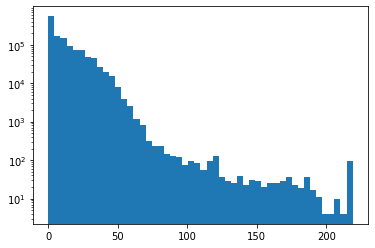

In [39]:
plt.hist(authors_careers['deltaYear'], bins=50)
plt.yscale('log')

In [40]:
authors_careers

,authorId,beginYear,wos_begin,lastYear,wos_last,deltaYear
0,18161,2008,[[Marine & Freshwater Biology]],2019,"[[Environmental Sciences], [Marine & Freshwate...",11
1,20361,1999,[[Neurosciences]],2004,"[[Biochemistry & Molecular Biology, Biophysics]]",5
2,39506,2010,"[[Neurosciences, Clinical Neurology, Gastroent...",2015,[[Cell Biology]],5
3,57623,2005,[[Respiratory System]],2009,"[[Respiratory System, Physiology]]",4
4,64128,2009,"[[Neurosciences, Clinical Neurology], [Neurosc...",2018,"[[Neurosciences, Behavioral Sciences]]",9
...,...,...,...,...,...,...
1290005,3035759232,2005,[[Neurosciences]],2019,[-1],14
1290006,3035760453,2012,[[Otorhinolaryngology]],2018,[-1],6
1290007,3035760604,2015,"[[Neurosciences], [Neurosciences]]",2015,"[[Neurosciences], [Neurosciences]]",0
1290008,3035761758,2008,"[[Neurosciences, Clinical Neurology]]",2018,"[[Behavioral Sciences, Neurosciences]]",10


In [46]:
# merge the careers with the original author file
authorsInPapers = pd.merge(authorsInPapers, authors_careers, on='authorId', how='left')

In [47]:
# save the file
authorsInPapers.to_csv(f'{path_output}collabNet_nodes.csv', sep=';', index=False)

## 4.3 - Build the parametrized temporal collaboration network
Build a temporal multilayer network with AI and non-AI collaborations. Therefore two authors can be linked in different way, either 'AI' or 'nonAI' with time.

In [ ]:
# NEUROAI
cn = {}
for y in tqdm(range(1970,2020)):
    for authors in papersAI[papersAI['publicationYear']==y]['authors']:
        if eval(authors) != -1:
            a = list(set(eval(authors))) # to avoid the case where authors appear twice in a single publication
            for i in range(len(a)-1):
                for j in range(i+1,len(a)):
                    if (a[i],a[j],y) in cn:
                        cn[(a[i],a[j],y)][0] += 1
                    elif (a[j],a[i],y) in cn:
                        cn[(a[j],a[i],y)][0] += 1
                    else:
                        cn[(a[i],a[j],y)] = [1,0]
print('NeuroAI ok')
# NEURO
for y in tqdm(set(papersNonAI['publicationYear'])):
    for authors in papersNonAI[papersNonAI['publicationYear']==y]['authors']:
        if eval(authors)!=-1:
            a = list(set(eval(authors))) # to avoid the case where authors appear twice in a single publication
            for i in range(len(a)-1):
                for j in range(i+1,len(a)):
                    if (a[i],a[j],y) in cn:
                        cn[(a[i],a[j],y)][1] += 1
                    elif (a[j],a[i],y) in cn:
                        cn[(a[j],a[i],y)][1] += 1
                    else:
                        cn[(a[i],a[j],y)] = [0,1]
print('Neuro ok')
collabNet = [(i,j,y,k,l) for ((i,j,y),[k,l]) in cn.items()]
collabNet = pd.DataFrame.from_records(collabNet, columns=['author1','author2','year','w_AI','w_nonAI'])
collabNet['w'] = [i+j for i,j in zip(collabNet['w_nonAI'],collabNet['w_AI'])]

In [ ]:
# confirmation
a1, a2, y = 2153041777, 20660026, 1973
# avoid doublons
print(a1 in list(collabNet[collabNet['author1']==a2]['author2']))
# verify the variables 'w_AI' and 'w_nonAI'
ids = set(allpapers[(allpapers['authors']==a1)]['id']) & set(allpapers[allpapers['authors']==a2]['id'])
allpapers[(allpapers['id'].isin(ids)) 
          & (allpapers['publicationYear']==y)
          & ((allpapers['authors']==a1)|(allpapers['authors']==a2))]

In [ ]:
collabNet.to_csv(f'{path_output}collabNet.csv', sep=';', index=False)
collabNet.rename(columns={'author1':'source','author2':'target'}).to_csv(f'{path_output}collabNet_edges_gephi.csv', sep=';', index=False)

## 4.5 - Build the time aggregated collaboration network

In [3]:
# add weights
def aggregate(temporal_collab_network):
    cn = {}
    for i,j,w in tqdm(temporal_collab_network[['author1','author2','w']].values):
        if (i,j) in cn:
            cn[(i,j)] += w
        elif (j,i) in cn:
            cn[(j,i)] += w
        else:
            cn[(i,j)] = w
    cn = pd.DataFrame.from_records([(i,j,k) for ((i,j),k) in cn.items()], columns=['author1','author2','w'])
    return cn

In [ ]:
collabNet_timeagg = aggregate(collabNet)

#### Verification by comparing to the weights of the original network

In [226]:
ind = np.where(collabNet_timeagg['w']==max(collabNet_timeagg['w']))
collabNet_timeagg.loc[ind]

,author1,author2,w
331035,2737824110,2999599514,297


In [228]:
sum(collabNet[((collabNet['author1']==2737824110) & (collabNet['author2']==2999599514))|
              ((collabNet['author2']==2737824110) & (collabNet['author1']==2999599514))]['w'])

297

In [ ]:
collabNet_timeagg.to_csv(f'{path_output}collabNet_edges_timeagg.csv', sep=';', index=False)

# 5 - Comparison of different time-aggregated collaboration networks when applying different filters
Compare:
- their density, 
- their number of connected components and the distribution of their corresponding sizes 

In [7]:
# add weights
def aggregate(temporal_collab_network):
    cn = {}
    for i,j,w in tqdm(temporal_collab_network[['author1','author2','w']].values):
        if (i,j) in cn:
            cn[(i,j)] += w
        elif (j,i) in cn:
            cn[(j,i)] += w
        else:
            cn[(i,j)] = w
    cn = pd.DataFrame.from_records([(i,j,k) for ((i,j),k) in cn.items()], columns=['author1','author2','w'])
    return cn

## 5.1 - Original time aggregated network with all the authors of the original database

In [32]:
collabNet = pd.read_csv(f'{path_output}collabNet.csv', sep=';')

In [33]:
collabNet_timeagg = aggregate(collabNet)

100%|███████████████████████████| 12637315/12637315 [00:19<00:00, 644415.70it/s]


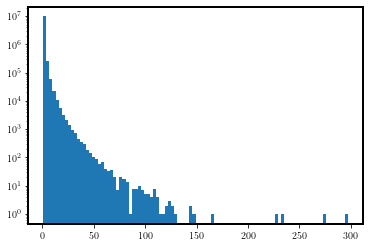

In [229]:
plt.hist(collabNet_timeagg['w'],bins=100)
plt.yscale('log')

In [230]:
G = ig.Graph.DataFrame(collabNet_timeagg, directed=False)

In [231]:
len(G.vs)

1278468

In [232]:
len(G.es)

10109269

In [233]:
G.density()

1.2370018924904797e-05

In [234]:
comp = [c for c in G.components()]
sizes = [len(c) for c in comp]

In [235]:
sorted(sizes)[-10:]

[30, 31, 31, 32, 32, 32, 34, 39, 41, 1166044]

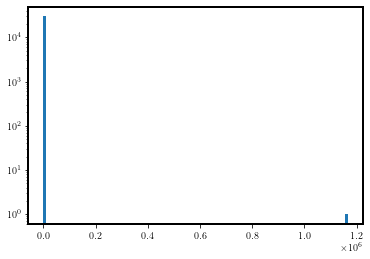

In [236]:
plt.hist(sizes,bins=100)
plt.yscale('log')

## 5.2 - Select only the authors having at least 3 publications

In [268]:
authorsInPapers_sub = authorsInPapers[authorsInPapers['nb_publi_all']>=3]

In [278]:
len(authorsInPapers_sub)

899706

In [269]:
sub_collabNet_timeagg = collabNet_timeagg[collabNet_timeagg['author1'].isin(authorsInPapers_sub['authorId'])
                         & collabNet_timeagg['author2'].isin(authorsInPapers_sub['authorId'])]

In [270]:
G = ig.Graph.DataFrame(sub_collabNet_timeagg, directed=False)

In [271]:
len(G.vs)

887227

In [350]:
887227/len(authorsInPapers)

0.6876977012590096

In [272]:
len(G.es)

7819355

In [273]:
G.density()

1.986698282284764e-05

In [274]:
comp = [c for c in G.components()]
sizes = [len(c) for c in comp]

In [275]:
len(comp)

16561

In [276]:
sorted(sizes)[-10:]

[24, 25, 25, 26, 27, 27, 28, 29, 30, 828240]

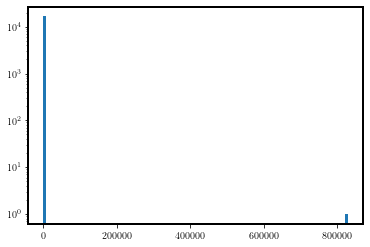

In [277]:
plt.hist(sizes,bins=100)
plt.yscale('log')

## 5.3 - Select only the authors with bounded careers ($\Delta t\leqslant 50\,years $ and $t_0\geqslant 1940$)

In [54]:
authorsInPapers_sub = authorsInPapers[(authorsInPapers['deltaYear']<=50) & (authorsInPapers['beginYear']>=1940)]

In [55]:
sub_collabNet_timeagg = collabNet_timeagg[collabNet_timeagg['author1'].isin(authorsInPapers_sub['authorId'])
                                         & collabNet_timeagg['author2'].isin(authorsInPapers_sub['authorId'])]

In [ ]:
G = ig.Graph.DataFrame(sub_collabNet_timeagg, directed=False)

In [251]:
len(G.vs)

1261059

In [252]:
len(G.es)

9641832

In [253]:
G.density()

1.2126042558122171e-05

In [254]:
comp = [c for c in G.components()]
sizes = [len(c) for c in comp]

In [257]:
len(comp)

32284

In [255]:
sorted(sizes)[-10:]

[31, 32, 32, 32, 34, 34, 39, 41, 45, 1140463]

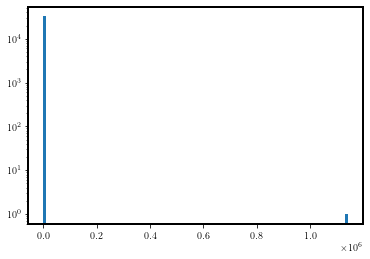

In [256]:
plt.hist(sizes,bins=100)
plt.yscale('log')

## 5.3 - Select only the authors with bounded careers ($\Delta t\leqslant 50\,years $ and $t_0\geqslant 1940$) and having at least 3 publications

In [20]:
authorsInPapers_sub = authorsInPapers[(authorsInPapers['nb_publi_all']>=3) &
                                      (authorsInPapers['deltaYear']<=50) &
                                      (authorsInPapers['beginYear']>=1940)]

In [20]:
sub_collabNet_timeagg = collabNet_timeagg[collabNet_timeagg['author1'].isin(authorsInPapers_sub['authorId'])
                         & collabNet_timeagg['author2'].isin(authorsInPapers_sub['authorId'])]

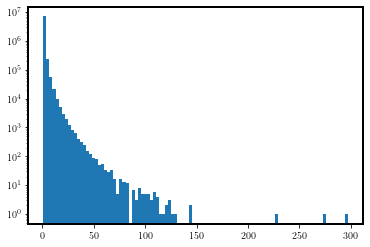

In [61]:
plt.hist(sub_collabNet_timeagg['w'],bins=100)
plt.yscale('log')

In [215]:
G = ig.Graph.DataFrame(sub_collabNet_timeagg, directed=False)

In [217]:
len(G.vs)

871282

In [218]:
len(G.es)

7420423

In [220]:
sum(sub_collabNet_timeagg['w'])

10785916

In [216]:
len(G.vs)/len(authorsInPapers)

0.6753385870226588

In [407]:
# share of removing edges
(sum(collabNet_timeagg['w'])-sum(sub_collabNet_timeagg['w']))/sum(collabNet_timeagg['w'])

0.2176531209689165

In [299]:
G.density()

1.9549770933834205e-05

In [242]:
comp = [c for c in G.components()]
sizes = sorted([len(c) for c in comp])

In [237]:
ind_sorted

array([8799, 5840, 5839, ..., 7410, 1192,    0])

In [222]:
len(comp)

17599

In [302]:
sorted(sizes)[-10:]

[25, 26, 27, 27, 27, 28, 28, 29, 30, 809280]

In [303]:
sum(sizes[:-1])

62002

In [408]:
# share of nodes in independent connected components, here 7.7%
62002/809280

0.07661378015025702

In [223]:
sizes[-1]/len(G.vs)

0.9288381947521009

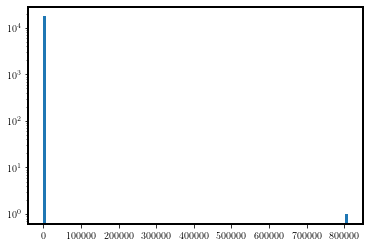

In [304]:
plt.hist(sizes,bins=100)
plt.yscale('log')

## 5.4 - Who are the problematic persons? 
Compare with the percentage of persons making AI wrt to the `AI_score` vs `nb_publi_all`

In [62]:
authorsInPapers_reject = authorsInPapers[~((authorsInPapers['nb_publi_all']>=3) &
                                           (authorsInPapers['deltaYear']<=50))
                                           (authorsInPapers['beginYear']>=1940)]
authorsInPapers_reject

,authorId,name,affiliation,queryLevel,nb_publi_neuro,AIscore_neuro,nb_publi_all,AIscore_all
2,2806045187,A.A.A. Pradhan,5023651,0.0,1.0,0.0,1,0.0
3,2974182613,A. A. Aarnisalo,NONE,0.0,1.0,0.0,2,0.0
5,2840631567,A A Abdel-Rahman,1309191912,0.0,1.0,0.0,1,0.0
6,2639413062,A.A. Acheampong,201448701,0.0,1.0,1.0,1,1.0
8,2437395452,A A Ajayi,45711476,0.0,1.0,0.0,1,0.0
...,...,...,...,...,...,...,...,...
1290136,2263707641,Е. Viteva,NONE,0.0,1.0,0.0,1,0.0
1290137,3022633000,Е Е Garanina,21203515,0.0,1.0,0.0,1,0.0
1290138,2688406403,Мikhail Pashenkov,NONE,0.0,1.0,0.0,1,0.0
1290139,2495571327,І. L. Popovych,149851306,0.0,1.0,0.0,1,0.0


In [90]:
len(authorsInPapers_reject)/len(authorsInPapers)

0.31319599950703064

### 5.4.1 - Study of the AI score of the rejected authors

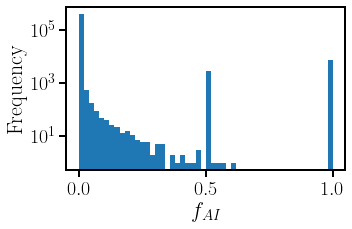

In [103]:
fig = plt.figure(figsize=(5, 3))
ax = plt.axes()
ax.hist(authorsInPapers_reject['AIscore_all'],bins=50)
ax.set_xlabel(r'$f_{AI}$', fontsize=axisLabelSize-3)
ax.set_ylabel(r'Frequency', fontsize=axisLabelSize-3)
ax.set_yscale('log')
ax.tick_params(which='major', labelsize=ticksLabelSize, length=7, width=ticksWidth)
ax.tick_params(which='minor', length=4, width=ticksWidth)
plt.savefig(f'{path_output}AIscore_distrib_RejectedAuthors.pdf', format='pdf', bbox_inches='tight')

In [91]:
len(authorsInPapers[authorsInPapers['AIscore_all']>0])/len(authorsInPapers)

0.15763935879876695

In [81]:
# fraction of rejected authors who are considered as AI-expert
len(authorsInPapers_reject[authorsInPapers_reject['AIscore_all']>=0.5])/len(authorsInPapers_reject)

0.02559971489876679

In [93]:
# loss of AI practitioners compared to the original authors' database above
len(authorsInPapers_reject[authorsInPapers_reject['AIscore_all']>0])/len(authorsInPapers[authorsInPapers['AIscore_all']>0])

0.0740103354853302

In [92]:
# loss of AI expert authors compared to the original authors' database above
len(authorsInPapers_reject[authorsInPapers_reject['AIscore_all']>=0.5])/len(authorsInPapers[authorsInPapers['AIscore_all']>=0.5])

0.6570121951219512

In [409]:
# share of authors having AIscore_all=1 in the rejected wrt to the whole set
len(authorsInPapers_reject[authorsInPapers_reject['AIscore_all']==1])/len(authorsInPapers[authorsInPapers['AIscore_all']==1])

0.945664739884393

### 5.4.2 - Study of the beginning year of the career

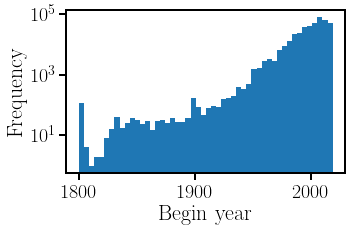

In [109]:
fig = plt.figure(figsize=(5, 3))
ax = plt.axes()
ax.hist(authorsInPapers_reject['beginYear'],bins=50)
ax.set_xlabel(r'Begin year', fontsize=axisLabelSize-3)
ax.set_ylabel(r'Frequency', fontsize=axisLabelSize-3)
ax.set_yscale('log')
ax.tick_params(which='major', labelsize=ticksLabelSize, length=7, width=ticksWidth)
ax.tick_params(which='minor', length=4, width=ticksWidth)
plt.savefig(f'{path_output}beginYear_distrib_RejectedAuthors.pdf', format='pdf', bbox_inches='tight')

In [116]:
len(authorsInPapers_reject[authorsInPapers_reject['beginYear']>=1940])/len(authorsInPapers_reject)

0.9947558201981355

### 5.4.2 - Study of the loss of links in the collaboration network

In [99]:
sub_collabNet_timeagg_rejected = collabNet_timeagg[collabNet_timeagg['author1'].isin(authorsInPapers_reject['authorId'])|
                                                   collabNet_timeagg['author2'].isin(authorsInPapers_reject['authorId'])]

In [100]:
sub_collabNet_timeagg_rejected['w'].sum()/sub_collabNet_timeagg['w'].sum()

0.2782053930329144

Results: removing the problematic researchers from the whole collaboration network rejects 27.8% of the edges and 31.3% of the authors. 
According to the results below, 15% of them have published at least one AI-related article. 
If we consider only the AI practitioners of the original database, 7.5% of them are rejected by the filtration.
If we consider the rather AI-experts ($f_{AI}\geqslant 0.5$), 65.7% of them are rejected by the filtration, who are at most young researchers, or scientists publishing episodically on traditional academic media such as peer-reviewed journals here, or scientists publishing not regularly in such journals (since $n_{publi} \leqslant 2$).
Moreover, givent their low number of publications in our database, they therefore don't represent a significant part of the collboration network, with a small ego-network.
In this way we conserve the authors with significant academic expience through the publications in the academic journals chosen to represent the neuroscience field, and who have respectively an ego-collaboration network that could be more extended (wider).

### 5.4.3 - Check the potential loss within the time-aggregated collaboration network of AI research (ie. within $\mathcal{P}\cap AI$) if we remove the problematic authors in it

In [46]:
papersAI['authors'] = papersAI['authors'].apply(lambda x: eval(x))

In [164]:
# share of authors in the subset having complete carrer and at least 3 publications
len(set(papersAI.explode('authors')['authors'])&set(authorsInPapers_sub['authorId']))/len(set(papersAI.explode('authors')['authors']))

0.8643376060703984

In [125]:
# who are the rejected ones?
authorsNeuroAI_rejected_ids = set(papersAI.explode('authors')['authors'])-(set(papersAI.explode('authors')['authors'])&set(authorsInPapers_sub['authorId']))
authorsNeuroAI_rejected = authorsInPapers[authorsInPapers['authorId'].isin(authorsNeuroAI_rejected_ids)]
authorsNeuroAI_rejected

,authorId,name,affiliation,queryLevel,nb_publi_neuro,AIscore_neuro,nb_publi_all,AIscore_all,beginYear,wos_begin,lastYear,wos_last,deltaYear
6,2639413062,A.A. Acheampong,201448701,0.0,1.0,1.000,1,1.000000,1988.0,"[['Neurosciences', 'Pharmacology & Pharmacy']]",1988.0,"[['Neurosciences', 'Pharmacology & Pharmacy']]",0.0
34,2699497383,A A Barnes,188950975,0.0,1.0,1.000,1,1.000000,2009.0,"[['Neurosciences', 'Clinical Neurology', 'Gast...",2009.0,"[['Neurosciences', 'Clinical Neurology', 'Gast...",0.0
210,2488445124,A A Kruglov,32389192,0.0,1.0,1.000,1,1.000000,2014.0,[['Cell Biology']],2014.0,[['Cell Biology']],0.0
510,2974365865,A. Agogino,86519309,0.0,1.0,1.000,1,1.000000,2000.0,[['Computer Science']],2000.0,[['Computer Science']],0.0
655,2495994358,A Al-Mohammed,NONE,0.0,1.0,1.000,1,1.000000,2005.0,[['Ophthalmology']],2005.0,[['Ophthalmology']],0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1289831,2536406627,Zvenislava Husak,NONE,0.0,1.0,1.000,1,1.000000,2001.0,"[['Cell Biology', 'Biochemistry & Molecular Bi...",2001.0,"[['Cell Biology', 'Biochemistry & Molecular Bi...",0.0
1289888,2770849496,Zvi Vogel,NONE,0.0,40.0,0.025,190,0.005263,1968.0,"[['Multidisciplinary Sciences'], ['Biochemistr...",2019.0,[['Multidisciplinary Sciences']],51.0
1290052,2120994696,Şehri Kılıç,67581229,0.0,1.0,1.000,1,1.000000,2001.0,[['Neurosciences']],2001.0,[['Neurosciences']],0.0
1290079,2276486861,Ştefan Mihalaş,145311948,0.0,1.0,1.000,1,1.000000,2009.0,"[['Neurosciences', 'Computer Science']]",2009.0,"[['Neurosciences', 'Computer Science']]",0.0


#### 5.4.3.1 - Distribution of the career durations of the authors in $\mathcal{P}\cap AI$

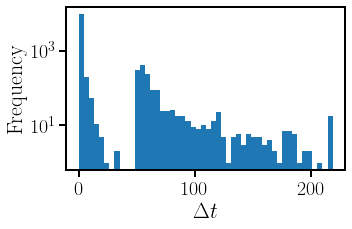

In [130]:
fig = plt.figure(figsize=(5, 3))
ax = plt.axes()
ax.hist(authorsNeuroAI_rejected['deltaYear'],bins=50)
ax.set_xlabel(r'$\Delta t$', fontsize=axisLabelSize-3)
ax.set_ylabel(r'Frequency', fontsize=axisLabelSize-3)
ax.set_yscale('log')
ax.tick_params(which='major', labelsize=ticksLabelSize, length=7, width=ticksWidth)
ax.tick_params(which='minor', length=4, width=ticksWidth)
plt.savefig(f'{path_output}Deltayear_distrib_RejectedAuthorsNeuroAI_ONLY.pdf', format='pdf', bbox_inches='tight')

In [138]:
# fraction of the authors having a career duration lower than or equal to 3
1-len(authorsNeuroAI_rejected[authorsNeuroAI_rejected['deltaYear']>3])/len(authorsNeuroAI_rejected)

0.833950944062114

#### 5.4.3.2 - Distribution of the publication years of their articles in  $\mathcal{P}\cap AI$

In [ ]:
# when are situated their main publications?
p = papersAI.explode('authors')
publis = p[p['authors'].isin(authorsNeuroAI_rejected['authorId'])].drop_duplicates('id')

In [165]:
len(publis)/len(papersAI['id'])

0.32623037840297264

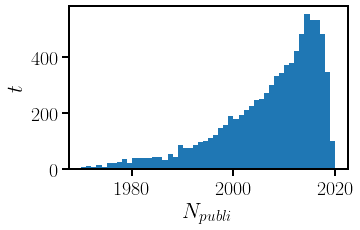

In [145]:
fig = plt.figure(figsize=(5, 3))
ax = plt.axes()
ax.hist(publis['publicationYear'],bins=50)
ax.set_xlabel(r'$N_{publi}$', fontsize=axisLabelSize-3)
ax.set_ylabel(r'$t$', fontsize=axisLabelSize-3)
#ax.set_yscale('log')
ax.tick_params(which='major', labelsize=ticksLabelSize, length=7, width=ticksWidth)
#ax.tick_params(which='minor', length=4, width=ticksWidth)
plt.savefig(f'{path_output}NbPublis_distrib_RejectedAuthorsNeuroAI_ONLY.pdf', format='pdf', bbox_inches='tight')

#### 5.4.3.3 - Loss in the collaboration network

In [153]:
# study the sub collaboration network in AI
cn = {}
for authors in papersAI['authors']:
    if authors != -1:
        a = list(set(authors)) # to avoid the case where authors appear twice in a single publication
        for i in range(len(a)-1):
            for j in range(i+1,len(a)):
                if (a[i],a[j]) in cn:
                    cn[(a[i],a[j])] += 1
                elif (a[j],a[i]) in cn:
                    cn[(a[j],a[i])] += 1
                else:
                    cn[(a[i],a[j])] = 1
collabNet_NeuroAI = [(i,j,k) for ((i,j),k) in cn.items()]
collabNet_NeuroAI = pd.DataFrame.from_records(collabNet_NeuroAI, columns=['author1','author2','w'])

In [154]:
collabNet_NeuroAI

,author1,author2,w
0,3024761849,2619442247,1
1,2145260682,2835622326,1
2,2995834608,2891704168,2
3,2995834608,2798335766,3
4,2995834608,2651595071,2
...,...,...,...
379002,712055444,2405690839,1
379003,712055444,2102785432,1
379004,2905290646,2405690839,1
379005,2905290646,2102785432,1


In [155]:
# share of total links of the subgraph of AI research if we remove problematic authors publishing in it
sum(collabNet_NeuroAI[collabNet_NeuroAI['author1'].isin(authorsInPapers_sub['authorId'])&
                      collabNet_NeuroAI['author2'].isin(authorsInPapers_sub['authorId'])]['w'])/sum(collabNet_NeuroAI['w'])

0.8302825444655331

In [158]:
# and among the whole collaboration network of the original database
sum(collabNet_timeagg[collabNet_timeagg['author1'].isin(authorsNeuroAI_rejected['authorId']) &
                      collabNet_timeagg['author2'].isin(authorsNeuroAI_rejected['authorId'])]['w'])/sum(collabNet_timeagg['w'])

0.00075769137256017

Results: the authors that have been removed in this little subset of authors in $\mathcal{P}\cap AI$ represent 14% of the subset of authors over only 33% of the publications of $\mathcal{P}\cap AI$. 

Removing these authors from the sub collaboration network of $\mathcal{P}\cap AI$ conserves 83% of its links.
The authors that have been removed in this little subset of authors in $\mathcal{P}\cap AI$ are thus not much driving the whole AI research in neuroscience.
Removing them from the whole unfiltered collaboration network of $\mathcal{P}\cap AI$ produces a loss of 0.08% of its links.
Their contributions in the original dataset is thus unsignificant.

# 6 - Quantify the loss of authors w.r.t the original dataset and the loss of AI authors doing AI
Compare the collaboration network a different steps of filtration, following the different sections, and with several indicators:
- Degree distribution
- The number of connected components
- The global clustering coefficient of their nodes

## 6.1 - Original database

In [5]:
papers_original = pd.read_csv(f'{path_output}citationNetwork_nodes.csv', sep=';')
papers_original_Ql0 = papers_original[papers_original['queryLevel']==0]
papers_original_Ql0['authors'] = papers_original_Ql0['authors'].apply(lambda x: eval(x))

/tmp/ipykernel_58691/2711815738.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  papers_original_Ql0['authors'] = papers_original_Ql0['authors'].apply(lambda x: eval(x))


In [6]:
allAuthors_original_Ql0 = papers_original_Ql0['authors']

In [6]:
# number of unique authors in the original database 
len(set(allAuthors_original_Ql0.explode())-{-1})

2753969

In [7]:
# build the original time-aggregated collaboration network
cn = {}
for p in tqdm(allAuthors_original_Ql0):
    if p!=-1:
        a = list(set(p)) # to avoid the case where authors appear twice in a single publication
        for i in range(len(a)-1):
            for j in range(i+1,len(a)):
                if (a[i],a[j]) in cn:
                    cn[(a[i],a[j])] += 1
                elif (a[j],a[i]) in cn:
                    cn[(a[j],a[i])] += 1
                else:
                    cn[(a[i],a[j])] = 1
cn = pd.DataFrame([(i,j,w) for (i,j),w in cn.items()], columns=['a1','a2','weight'])

100%|██████████████████████████████| 2139745/2139745 [00:34<00:00, 62873.30it/s]


In [8]:
G_original = nx.from_pandas_edgelist(cn, source='a1', target='a2', edge_attr='weight', create_using=nx.Graph, edge_key=None)

In [21]:
len(G_original.nodes)

2667552

In [28]:
(len(set(allAuthors_original_Ql0.explode())-{-1}) - len(G_original.nodes))/len(set(allAuthors_original_Ql0.explode())-{-1})

0.031379075073103585

Result: We count only 3% of authors who have published alone in the original dataset.

In [12]:
# distribution of the size of the connected components
c = [i for i in nx.connected_components(G_original)]
lenc = [len(i) for i in c]

In [29]:
len(lenc)

105418

In [27]:
(sum(lenc)-max(lenc))/sum(lenc)

0.14580934129868883

Results: the giant component of the collaboration network, without the alone authors, concentrates 85% of all the authors of the dataset, the other 15% being distributed among 105417 smaller components

In [10]:
# degree distribution
degree_freq = nx.degree_histogram(G_original)

In [13]:
# clustering coefficient only on the giant component
clustering_coeff = nx.average_clustering(G_original, nodes=c[0], weight='weight', count_zeros=True)

In [14]:
clustering_coeff

0.0008614775643829713

## 6.2 - Collaboration network from the filtered databases $\mathcal{P}\cap AI$ and $\mathcal{P}\cap \overline{AI}$

In [15]:
collabNet = pd.read_csv(f'{path_output}collabNet.csv', sep=';')
collabNet_timeagg = aggregate(collabNet)

100%|███████████████████████████| 12637315/12637315 [00:19<00:00, 648584.31it/s]


In [16]:
G_filtered = nx.from_pandas_edgelist(collabNet_timeagg, source='author1', target='author2', edge_attr='w', create_using=nx.Graph, edge_key=None)

In [37]:
(1290141-len(G_filtered.nodes))/1290141

0.00904784825844617

Result: 1% of the authors of the filtered database are publishing alone

In [17]:
# distribution of the size of the connected components
c = [i for i in nx.connected_components(G_filtered)]
lenc = [len(i) for i in c]

In [39]:
len(lenc)

29618

In [40]:
(sum(lenc)-max(lenc))/sum(lenc)

0.08793649899723732

Results: the giant component of the filtered collaboration network, without the alone authors, concentrates 91% of all the authors of the dataset, the other 9% being distributed among 29617 smaller components

In [18]:
# degree distribution
degree_freq_filtered = nx.degree_histogram(G_filtered)

In [62]:
# clustering coefficient only on the giant component
clustering_coeff_filtered = nx.average_clustering(G_filtered, nodes=c[0], weight='w', count_zeros=True)

In [81]:
clustering_coeff_filtered

0.0034082006306942595

## 6.3 - Filtered collaboration network considering only authors with careers length lower than 50 years and a minimal number of publications set at 3

In [19]:
authorsInPapers = pd.read_csv(f'{path_output}collabNet_nodes.csv', sep=';')
authorsInPapers_sub = authorsInPapers[(authorsInPapers['nb_publi_all']>=3) &
                                      (authorsInPapers['deltaYear']<=50) &
                                      (authorsInPapers['beginYear']>=1940)]
sub_collabNet_timeagg = collabNet_timeagg[collabNet_timeagg['author1'].isin(authorsInPapers_sub['authorId'])
                                         & collabNet_timeagg['author2'].isin(authorsInPapers_sub['authorId'])]

In [20]:
G_filtered_bis = nx.from_pandas_edgelist(sub_collabNet_timeagg, source='author1', target='author2', edge_attr='w', create_using=nx.Graph, edge_key=None)

In [21]:
len(G_filtered_bis.nodes())

871282

In [22]:
(886074-len(G_filtered_bis.nodes))/886074

0.016693865297932226

Result: 1,7% of the authors of the filtered database are publishing alone

In [23]:
# distribution of the size of the connected components
c = [i for i in nx.connected_components(G_filtered_bis)]
lenc = [len(i) for i in c]

In [24]:
len(lenc)

17599

In [25]:
(sum(lenc)-max(lenc))/sum(lenc)

0.07116180524789907

Results: the giant component of the filtered collaboration network, without the alone authors, concentrates 93% of all the authors of the dataset, the other 7% being distributed among 17598 smaller components

In [26]:
# degree distribution
degree_freq_filtered_bis = nx.degree_histogram(G_filtered_bis)

In [27]:
# clustering coefficient only on the giant component
clustering_coeff_filtered_bis = nx.average_clustering(G_filtered_bis, nodes=c[0], weight='w', count_zeros=True)

In [28]:
clustering_coeff_filtered_bis

0.0033415793673618496

## 6.4  - Compare the 3 degree distributions of the previous networks

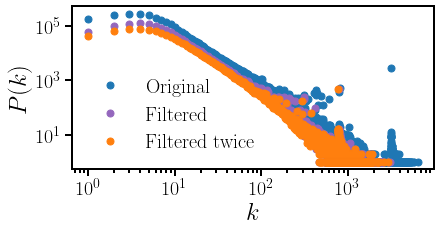

In [29]:
cmap = plt.cm.tab20.colors
ig = plt.figure(figsize=(6.5, 3))
ax = plt.axes()
ax.plot(range(len(degree_freq)), degree_freq, marker='o',
        linewidth=0, color=cmap[0], markersize=7, label=r'Original', alpha=1)
ax.plot(range(len(degree_freq_filtered)), degree_freq_filtered, marker='o',
        linewidth=0, color=cmap[8], markersize=7, label=r'Filtered', alpha=1)
ax.plot(range(len(degree_freq_filtered_bis)), degree_freq_filtered_bis, marker='o',
        linewidth=0, color=cmap[2], markersize=7, label=r'Filtered twice', alpha=1)
ax.set_xlabel(r'$k$', fontsize=axisLabelSize)
ax.set_xscale('log')
ax.set_ylabel(r'$P(k)$', fontsize=axisLabelSize)
ax.set_yscale('log')
#ax.set_ylim(0.4,1e7)
#ax.set_xlim(0.6,1e5)
#ax.set_xticks([10**i for i in range(6)], [10**i for i in range(6)])
ax.tick_params(which='major', labelsize=ticksLabelSize, length=7, width=ticksWidth)
ax.tick_params(which='minor', length=4, width=ticksWidth)
ax.legend(loc='best', ncol=1, fontsize=legendSize, frameon=False)
plt.savefig(f'{path_output}degree_distribs_OriginalDataset_vs_FilteredDataset_vs_FilteredDatasetBIS.pdf', format='pdf', bbox_inches='tight')

# 6.5 - Compare the distances between them with the Network Portrait Divergence
Refs:
- https://github.com/bagrow/network-portrait-divergence
- Bagrow & Bollt (2019): https://appliednetsci.springeropen.com/articles/10.1007/s41109-019-0156-x
- Other methods of network comparison and alignment in Tantardini et al. (2019): https://www.nature.com/articles/s41598-019-53708-y

In [4]:
path_output = r'/home/sylvain/DOCTORAT/PUBLICATIONS/2_AI_EpistemicIntegration_SocialSegregation/dataset_Zenodo/'
path_input = r'/home/sylvain/DOCTORAT/PUBLICATIONS/2_AI_EpistemicIntegration_SocialSegregation/dataset_Zenodo/'

In [30]:
path_code = r'/home/sylvain/DOCTORAT/DATA/microsoft_academic/codes/network_portrait_divergence_master/'
os.chdir(path_code)

In [31]:
from portrait_divergence import portrait_divergence

In [ ]:
d_Original_Filtered = portrait_divergence(G_original,G_filtered)
d_Original_Filtered

In [ ]:
d_Original_FilteredBis = portrait_divergence(G_original,G_filtered_bis)
d_Original_FilteredBis

In [ ]:
d_Filtered_FilteredBis = portrait_divergence(G_filtered,G_filtered_bis)
d_Filtered_FilteredBis